In [1]:
import os
import numpy as np
import time
import copy
import sys
import scipy.io

import matplotlib
import matplotlib.pyplot as plt

ang_2_bohr = 1.0/0.52917721067
hart_2_ev = 27.21138602

import cp2k_utilities as cu

In [2]:
folder = "/home/kristjan/local_work/cp2k_na_ribbon/scf/"

file_cp2k_inp = folder + "cp2k.inp"
file_cp2k_out = folder + "cp2k.out"

file_basis_set = folder + "BR"
file_xyz = folder + "p_opt_centered.xyz"

file_restart = folder + "PROJ-RESTART.wfn"

file_hartree = folder + "PROJ-HART-v_hartree-1_0.cube"

In [3]:
emin = -2.0 # eV
emax =  2.0 # eV

In [4]:
time1 = time.time()
elem_basis_names, cell = cu.read_cp2k_input(file_cp2k_inp)
print("Read cp2k input: %.3f" % (time.time()-time1))

time1 = time.time()
fermi = cu.read_fermi_from_cp2k_out(file_cp2k_out)
print("Read cp2k out: %.3f" % (time.time()-time1))

time1 = time.time()
at_positions, at_elems = cu.read_atoms(file_xyz)
print("Read xyz: %.3f" % (time.time()-time1))

time1 = time.time()
basis_sets = cu.read_basis_functions(file_basis_set, elem_basis_names)
print("Read basis sets: %.3f" % (time.time()-time1))

# RESTART FILE

time1 = time.time()
morb_composition, morb_comp_rev, morb_energies, morb_occs, ref_energy = cu.load_restart_wfn_file(
                                                                            file_restart, emin, emax, fermi)
print("Found %d orbitals" % len(morb_energies))
print("Read restart: %.3f" % (time.time()-time1))

# HARTREE CUBE

time1 = time.time()
hart_cube_data = cu.read_cube_file(file_hartree)
hart_cube = hart_cube_data[-1]
hart_cell = hart_cube_data[5]
print("Read hartree: %.3f" % (time.time()-time1))

Read cp2k input: 0.001
Read cp2k out: 0.014
Read xyz: 0.010
Read basis sets: 0.003
First molecular index in energy range:  677
Found 82 orbitals
Read restart: 1.041
Read hartree: 42.273


# Plane definition

In [5]:
# Define the plane

#height = 2.5 # Plane distance in z direction from topmost atom; angstroms

height = 3.5

#carb_positions = at_positions[np.array(at_elems)[:, 0] == 'C']
plane_z = np.max(at_positions[:, 2]) + height*ang_2_bohr # in BOHR!

# Use same grid as in the hartree cube file
cell_n = np.shape(hart_cube)

# CELL AND DV IN BOHR
dv = cell[0:2]/cell_n[0:2]
x_arr = np.arange(0, cell[0], dv[0])
y_arr = np.arange(0, cell[1], dv[1])

min: 2.4616; max: 3.4194; avg: 2.7918 (eV)
(comparison w Leo) min: 0.018003; max: 0.053203; avg: 0.030139 (au)


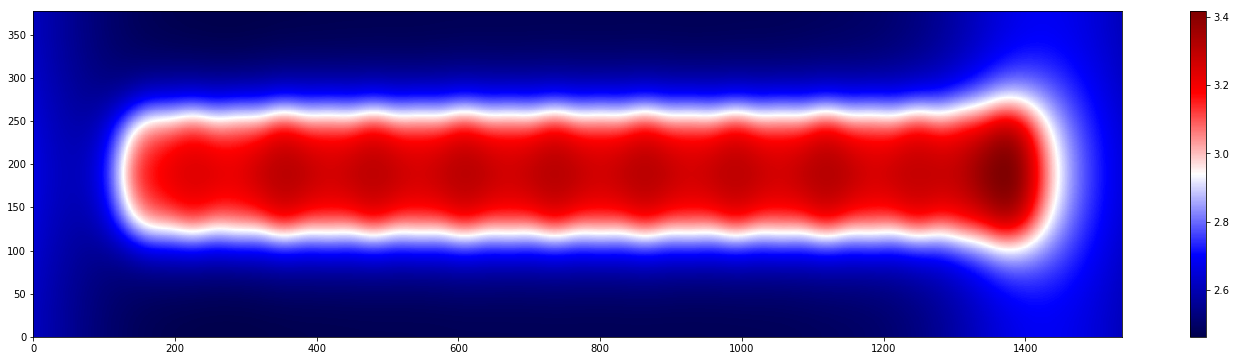

In [6]:
# Hartree potential on the plane

plane_index = int(np.round(plane_z/ang_2_bohr/hart_cell[2, 2]*np.shape(hart_cube)[2]))
hart_plane = hart_cube[:, :, plane_index] - ref_energy/hart_2_ev

print("min: %.4f; max: %.4f; avg: %.4f (eV)" % (np.min(hart_plane)*hart_2_ev,
                                                np.max(hart_plane)*hart_2_ev,
                                                np.mean(hart_plane)*hart_2_ev))

print("(comparison w Leo) min: %.6f; max: %.6f; avg: %.6f (au)" % (np.min(hart_plane)+ref_energy/hart_2_ev,
                                                                   np.max(hart_plane)+ref_energy/hart_2_ev,
                                                                   np.mean(hart_plane)+ref_energy/hart_2_ev))
fig_size = 6
plt.figure(figsize=(fig_size*hart_plane.shape[0]/hart_plane.shape[1], fig_size))
plt.pcolormesh(hart_plane.T*hart_2_ev, cmap='seismic')
plt.colorbar()
plt.show()

simple_hartree_avg = np.mean(hart_plane)

# Molecular orbitals on the plane

In [7]:
# Calculate molecular orbitals on the plane

morb_planes = cu.calc_morb_planes(cell[0:2], cell_n[0:2], plane_z,
                                  at_positions, at_elems,
                                  basis_sets, morb_comp_rev)

Main plane:    [ 196.53151705   47.24315314] (1536, 378)
Local plane:  [ 18.89726125  18.89726125] [148 152]
---- Setup: 0.0301
---- Radial calc time : 4.954121
---- Spherical calc time : 0.293606
---- Loc -> loc_morb time : 15.289082
---- loc_morb -> glob time : 3.551555
---- Total time: 24.7592


In [8]:
i_homo = 0

for i, en in enumerate(morb_energies):
    if en > 0.0:
        i_homo = i - 1
        break
    if np.abs(en) < 1e-6:
        i_homo = i
print(i_homo)

15


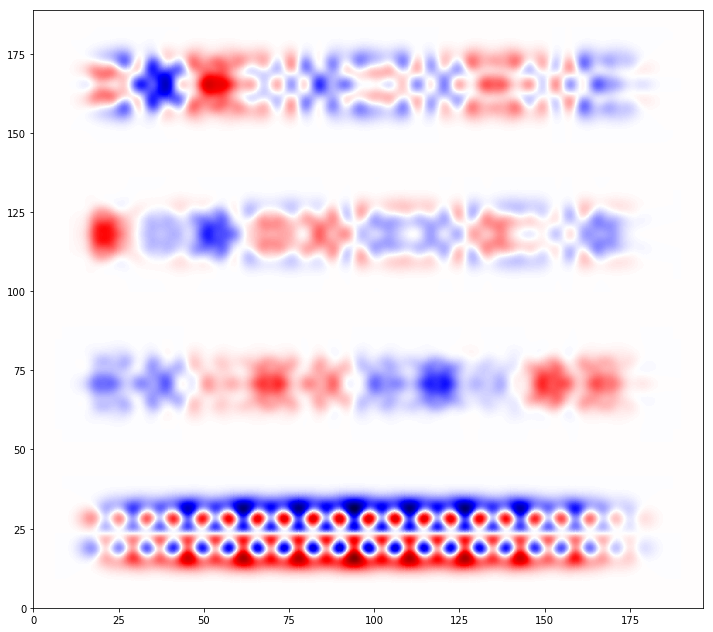

In [9]:
select = [i_homo - 5, i_homo, i_homo+1, i_homo + 4]

sel_morbs = np.zeros((cell_n[0], 4*cell_n[1]))

for i, i_mo in enumerate(select):
    sel_morbs[:, i*cell_n[1]:(i+1)*cell_n[1]] = morb_planes[i_mo]
    
y_arr_inc = np.arange(0, 4*cell[1], dv[1])

x_grid_inc, y_grid_inc = np.meshgrid(x_arr, y_arr_inc, indexing='ij')

max_val = np.max(sel_morbs)

plt.figure(figsize=(12, int(cell[1]/cell[0]*12*4)))
plt.pcolormesh(x_grid_inc, y_grid_inc, sel_morbs, vmax=max_val, vmin=-max_val, cmap='seismic') # seismic bwr
#plt.axvline(np.max(x_grid_inc)/2)
plt.show()

# STM plane

In [10]:
# Define the plane

stm_height = 5.0 # Plane distance in z direction from topmost atom; angstroms

stm_plane_z = np.max(at_positions[:, 2]) + stm_height*ang_2_bohr # in BOHR!

# Use same step and cell_n as before

# Extrapolation

In [11]:
def extrapolate_morbs(use_weighted_avg):
    # NB: everything in hartree units!
    extrap_planes = []
    time1 = time.time()
    for morb_index in range(len(morb_planes)):
        
        if use_weighted_avg:
            # weigh the hartree potential by the molecular orbital
            density_plane = morb_planes[morb_index]**2
            density_plane /= np.sum(density_plane)
            weighted_hartree = hart_plane * density_plane
            hartree_avg = np.sum(weighted_hartree)
        else:
            hartree_avg = simple_hartree_avg

        energy = morb_energies[morb_index]/hart_2_ev
        if energy > hartree_avg:
            print("Warning: unbound state, can't extrapolate! index: %d. Exiting." % morb_index)
            break

        fourier = np.fft.rfft2(morb_planes[morb_index])
        # NB: rfft2 takes REAL fourier transform over last (y) axis and COMPLEX over other (x) axes
        # dv in BOHR, so k is in 1/bohr
        kx_arr = 2*np.pi*np.fft.fftfreq(morb_planes[morb_index].shape[0], dv[0])
        ky_arr = 2*np.pi*np.fft.rfftfreq(morb_planes[morb_index].shape[1], dv[1])

        kx_grid, ky_grid = np.meshgrid(kx_arr, ky_arr, indexing='ij')

        delta_z = (stm_plane_z - plane_z)

        prefactors = np.exp(-np.sqrt(kx_grid**2 + ky_grid**2 - 2*(energy - hartree_avg))*delta_z)
        extrap_plane = np.fft.irfft2(fourier*prefactors, morb_planes[morb_index].shape)
        extrap_planes.append(extrap_plane)
    print("Time: %.3f s"%(time.time()-time1))
    return extrap_planes

extrap_planes_wavg = extrapolate_morbs(True)
extrap_planes_simp = extrapolate_morbs(False)

Time: 4.063 s
Time: 4.094 s


In [12]:
# Orbitals at stm distance without extrapolation
noextr_morb_planes = cu.calc_morb_planes(cell[0:2], cell_n[0:2], stm_plane_z,
                                  at_positions, at_elems,
                                  basis_sets, morb_composition)

Main plane:    [ 196.53151705   47.24315314] (1536, 378)
Local plane:  [ 18.89726125  18.89726125] [148 152]
---- Setup: 0.0387
---- Radial calc time : 4.116295
---- Spherical calc time : 0.206222
---- Loc -> glob time : 36.715072
---- Total time: 42.0873


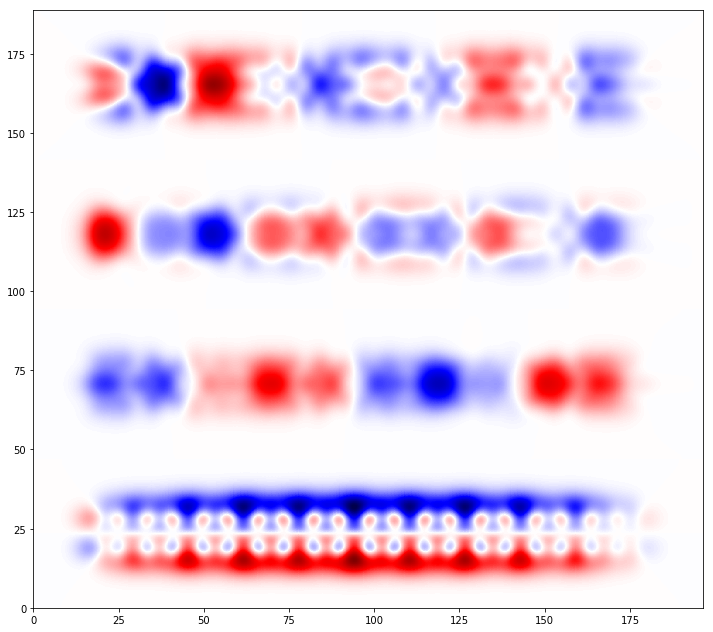

In [13]:
select = [i_homo - 5, i_homo, i_homo+1, i_homo + 4]

sel_morbs = np.zeros((cell_n[0], 4*cell_n[1]))

for i, i_mo in enumerate(select):
    # morb_planes noextr_morb_planes extrap_planes_simp extrap_planes_wavg
    sel_morbs[:, i*cell_n[1]:(i+1)*cell_n[1]] = extrap_planes_wavg[i_mo]
    
y_arr_inc = np.arange(0, 4*cell[1], dv[1])

x_grid_inc, y_grid_inc = np.meshgrid(x_arr, y_arr_inc, indexing='ij')

max_val = np.max(sel_morbs)

plt.figure(figsize=(12, int(cell[1]/cell[0]*12*4)))
plt.pcolormesh(x_grid_inc, y_grid_inc, sel_morbs, vmax=max_val, vmin=-max_val, cmap='seismic') # seismic bwr
#plt.axvline(np.max(x_grid_inc)/2)
plt.show()

# Summing orbitals

In [39]:
vbias = -1.0

for i, morb_en in enumerate(morb_energies):
    if morb_en > 

0 -1.95408365637
1 -1.88605519085
2 -1.77287756551
3 -1.69037853658
4 -1.63611884018
5 -1.00111006957
6 -0.538471636066
7 -0.206935890799
8 -0.173752609179
9 -0.10185123233
10 -0.0437026152645
11 -0.0258399245495
12 -0.0119609067591
13 -0.0100430931875
14 -0.00483327794873
15 -0.000258807522802
16 0.00856682890289
17 0.0130084629605
18 0.0174417247127
19 0.0199750923221
20 0.0233914979862
21 0.0256571951255
22 0.0436739258234
23 0.0972433664649
24 0.17240839946
25 0.209212517788
26 0.325223120165
27 0.330393154906
28 0.446297669714
29 0.500341506422
30 0.572153084835
31 0.608687150543
32 0.629243510425
33 0.632615696645
34 0.633931764748
35 0.6382925356
36 0.641733619522
37 0.645046621282
38 0.649235851496
39 0.650746397493
40 0.679368656688
41 0.696191426073
42 0.698853248416
43 0.773286857032
44 0.795976439767
45 0.829837746381
46 0.848985372798
47 0.856617815029
48 0.886924484827
49 0.892337353049
50 0.921743418488
51 0.964035162
52 0.975349438838
53 0.993630980408
54 1.03292297805
